### Segmentation 02 (3D)

In [7]:
%run ../utils.py
%run models.py
import os
import os.path as osp
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvutils import visualize
from codex import io as codex_io
from codex import config as codex_config
from skimage import feature
from skimage import filters
from skimage import measure
from skimage import segmentation
from skimage import morphology
from skimage import draw
from skimage import exposure
from scipy import ndimage

plt.gray()
init_session()

# exp_name = '20180611_D18_PMBC_500G'
# exp_conf_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'config')
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'nodeconv')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 0
# mem_ch = 2
# best_z = 21
# #crop = [slice(0, 512), slice(0, 512)]
# crop = [slice(None, None), slice(None, None)]

exp_name = '7-7-17-multicycle'
exp_conf_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle')
exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle-out-none', '1-Processor')
nuc_cyc = 0
nuc_ch = 0
mem_cyc = 2
mem_ch = 1
best_z = 4
crop = [slice(0, 512), slice(0, 512)]
# #crop = [slice(None, None), slice(None, None)]

model_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'modeling', 'cytopy', 'models', 'nuclei', 'v0.1')
model_path = osp.join(model_dir, 'nuclei_model.h5')

<Figure size 432x288 with 0 Axes>

In [8]:
exp_conf = codex_config.load(exp_conf_dir)

In [9]:
tile = codex_io.read_tile(osp.join(exp_data_dir, 'reg001_X01_Y01.tif'), exp_conf)
tile = tile[:, :, :, crop[0], crop[1]]
tile.shape, tile.dtype

((8, 9, 4, 512, 512), dtype('uint16'))

In [10]:
if tile.dtype == np.uint16:
    tile = exposure.rescale_intensity(tile, in_range=np.uint16, out_range=np.uint8).astype(np.uint8)

In [11]:
exp_conf.channel_names

['HOECHST1',
 'CollagenIV',
 'CD7',
 'Ki67',
 'HOECHST2',
 'CD38',
 'CD31',
 'CD4',
 'HOECHST3',
 'CD45',
 'CD90',
 'CD19',
 'HOECHST4',
 'CD15',
 'CD3',
 'CD104',
 'HOECHST5',
 'CD21',
 'CD34',
 'CD278',
 'HOECHST6',
 'HLADR',
 'CD22',
 'CD279',
 'HOECST7',
 'CD8',
 'CD40',
 'cytokeratin',
 'HOECHST8',
 'CD9',
 'Podoplanin',
 'CD11c']

In [48]:
img_nuc = tile[nuc_cyc, best_z, nuc_ch]
# plt.imshow(img_nuc)
# plt.gcf().set_size_inches(12, 12)

In [46]:
def prepocess(img, thresh, dilation_factor=1, erosion_factor=0):
    img = img > thresh
    img = morphology.remove_small_holes(img, area_threshold=6)
    if erosion_factor > 0:
        img = morphology.erosion(img, selem=morphology.diamond(erosion_factor))
    img = morphology.remove_small_objects(img, min_size=8)
    return img


def get_segmentation_mask(img_bin_nuci, img_bin_memb=None, dilation_factor=0):
    if img_bin_memb is None:
        if dilation_factor > 0:
            return morphology.dilation(img_bin_nuci, selem=morphology.disk(dilation_factor))
        else:
            return img_bin_nuci
    else:
        raise NotImplementedError()
        
        
def get_pred_img_overlay(img_pred, chs=[0, 1, 2]):
    return np.stack([
        exposure.rescale_intensity(img_pred[0][..., yi], out_range=np.uint8).astype(np.uint8)
        for yi in chs
    ], -1)
        
class Segmentation2D(object):
    
    def __init__(self, model):
        self.model = model
        
    def segment_image(self, img, nucleus_dilation=8, preproc_dilation=0, proba_threshold=.6):
        assert img.ndim == 2, 'Expecting 2D grayscale image but got shape {}'.format(img.shape)
        assert img.dtype == np.uint8, 'Expecting uint8 but got {}'.format(img.dtype)
        img_pred = model.predict(np.expand_dims(np.expand_dims(img/255., 0), -1))
        
        img_bin_nuci = prepocess(img_pred[0, ..., 0], proba_threshold)
        img_bin_nucb = prepocess(img_pred[0, ..., 1], proba_threshold)
        img_bin_nucm = prepocess(img_pred[0, ..., 2], proba_threshold)

        img_bin_nucm = img_bin_nucm & img_bin_nuci & ~img_bin_nucb

        img_bin_nucm_label = morphology.label(img_bin_nucm)
        img_bin_nuci_basin = ndimage.distance_transform_edt(img_bin_nuci)
        img_bin_nucb_basin = ndimage.distance_transform_edt(img_bin_nucb)
        img_basin = -img_bin_nuci_basin + img_bin_nucb_basin
        
        seg_mask = get_segmentation_mask(img_bin_nuci, dilation_factor=nucleus_dilation)
        img_seg = segmentation.watershed(img_basin, img_bin_nucm_label, mask=seg_mask)
        
        return img_seg, img_pred[0], np.stack([img_bin_nuci, img_bin_nucb, img_bin_nucm], axis=-1)

In [17]:
input_shape = img_nuc.shape + (1,)
model = get_nuclei_model_v1(input_shape)
model.load_weights(model_path)

In [28]:
segmenter = Segmentation2D(model)

In [29]:
img_seg, img_pred, img_bin = segmenter.segment_image(img_nuc)
img_border = segmentation.find_boundaries(img_seg, mode='inner', background=img_seg.min())

In [30]:
# crop = [slice(0, None), slice(0, None)]
# plt.imshow(img_pred[crop])
# plt.gcf().set_size_inches(24, 24)

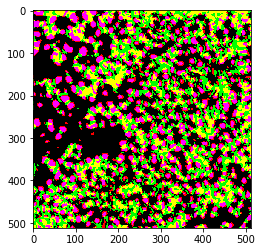

In [47]:
crop = [slice(0, None), slice(0, None)]
plt.imshow(img_bin[crop].astype(float))
#plt.gcf().set_size_inches(24, 24)

In [44]:
# img_seg_border = img_seg.copy()
# img_seg_border[img_border > 0] = -20
#img_seg_border[img_com > 0] = -30

img_nuc_border = img_nuc.copy()
#img_nuc_border[img_bin[..., 1] > 0] = -50
img_nuc_border[img_bin[..., 2] > 0] = -20
img_nuc_border[img_border > 0] = -1

# img_mem_border = img_mem.copy()
# img_mem_border[border_img > 0] = -20

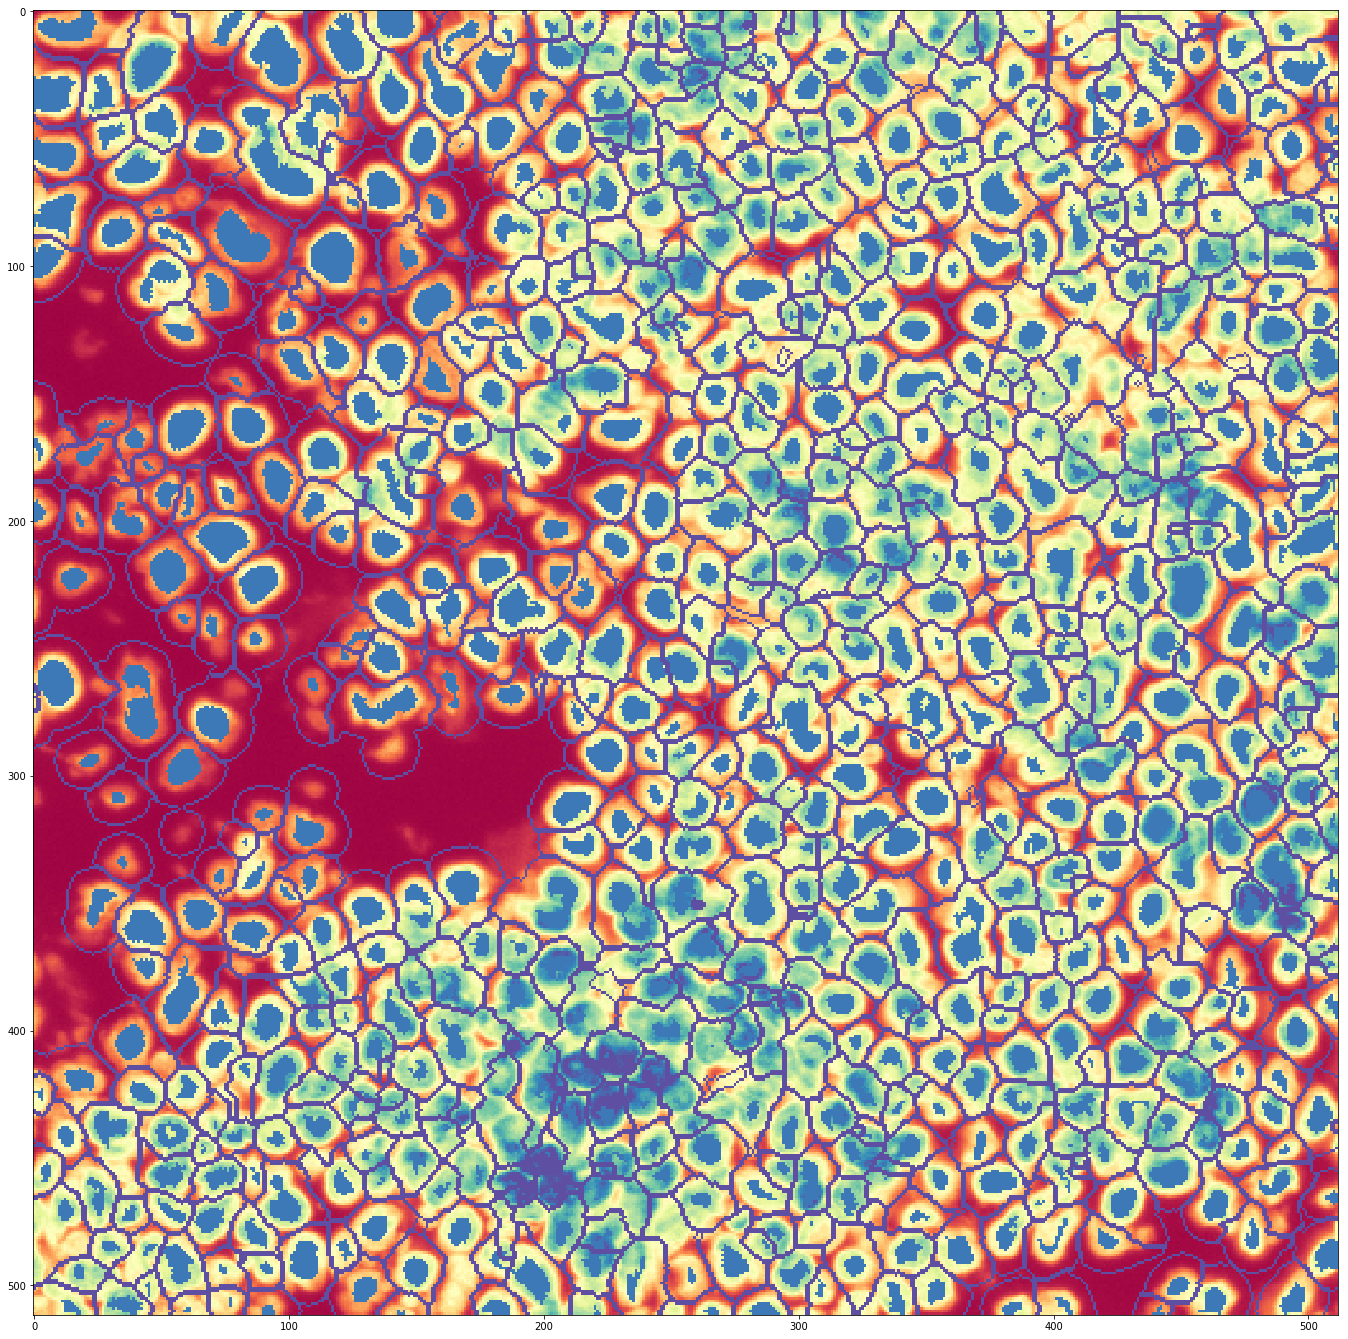

In [45]:
#crop = [slice(0, 256), slice(0, 256)]
#crop = [slice(0, 512), slice(0, 512)]
crop = [slice(0, None), slice(0, None)]
plt.imshow(img_nuc_border[crop], cmap='Spectral')
plt.gcf().set_size_inches(24, 24)

### 3D Watershed

In [99]:
def prepocess(img, thresh, erosion_factor=0):
    img = img > thresh
    img = morphology.remove_small_holes(img, area_threshold=8)
    if erosion_factor > 0:
        img = morphology.erosion(img, selem=morphology.ball(erosion_factor))
    img = morphology.remove_small_objects(img, min_size=8)
    return img


def get_segmentation_mask(img_bin_nuci, img_bin_memb=None, dilation_factor=0):
    if img_bin_memb is None:
        if dilation_factor > 0:
            return morphology.dilation(img_bin_nuci, selem=morphology.ball(dilation_factor))
        else:
            return img_bin_nuci
    else:
        raise NotImplementedError()

class Segmentation3D(object):
    
    def __init__(self, model):
        self.model = model
        
    def segment_volume(self, img, nucleus_dilation=8, preproc_dilation=0, proba_threshold=.6):
        assert img.ndim == 3, 'Expecting 3D grayscale image but got shape {}'.format(img.shape)
        assert img.dtype == np.uint8, 'Expecting uint8 but got {}'.format(img.dtype)
        img_pred = model.predict(np.expand_dims(img/255., -1))
        
        img_bin_nuci = prepocess(img_pred[..., 0], proba_threshold)
        img_bin_nucb = prepocess(img_pred[..., 1], proba_threshold)
        img_bin_nucm = prepocess(img_pred[..., 2], proba_threshold)

        img_bin_nucm = img_bin_nucm & img_bin_nuci & ~img_bin_nucb

        img_bin_nucm_label = morphology.label(img_bin_nucm)
        img_bin_nuci_basin = ndimage.distance_transform_edt(img_bin_nuci)
        img_bin_nucb_basin = ndimage.distance_transform_edt(img_bin_nucb)
        img_basin = -img_bin_nuci_basin + img_bin_nucb_basin
        
        seg_mask = get_segmentation_mask(img_bin_nuci, dilation_factor=nucleus_dilation)
        img_seg = segmentation.watershed(img_basin, img_bin_nucm_label, mask=seg_mask)
        
        return img_seg, img_pred, np.stack([img_bin_nuci, img_bin_nucb, img_bin_nucm], axis=-1)


In [100]:
img_nuc = tile[nuc_cyc, :, nuc_ch]
img_nuc.shape

(9, 512, 512)

In [101]:
segmenter = Segmentation3D(model)

In [ ]:
img_seg, img_pred, img_bin = segmenter.segment_volume(img_nuc)
img_border = segmentation.find_boundaries(img_seg, mode='inner', background=img_seg.min())

In [104]:
img_seg.shape, img_bin.shape, img_pred.shape

((9, 512, 512), (9, 512, 512, 3), (9, 512, 512, 3))

In [105]:
# crop = [slice(0, None), slice(0, None)]
# visualize.display_images([img_bin[i][crop].astype(float) for i in range(img_bin.shape[0])], size=24, cols=3)

In [106]:
img_nuc.shape, img_bin.shape, img_border.shape

((9, 512, 512), (9, 512, 512, 3), (9, 512, 512))

In [107]:
img_nuc_border = img_nuc.copy()
img_nuc_border[img_bin[..., 2] > 0] = -20
img_nuc_border[img_border > 0] = -1

In [108]:
# crop = [slice(0, 256), slice(0, 256)]
# visualize.display_images([
#     img_seg[i][crop].astype(float) 
#     for i in range(img_seg.shape[0])
# ], size=24, cols=3, cmap='viridis')

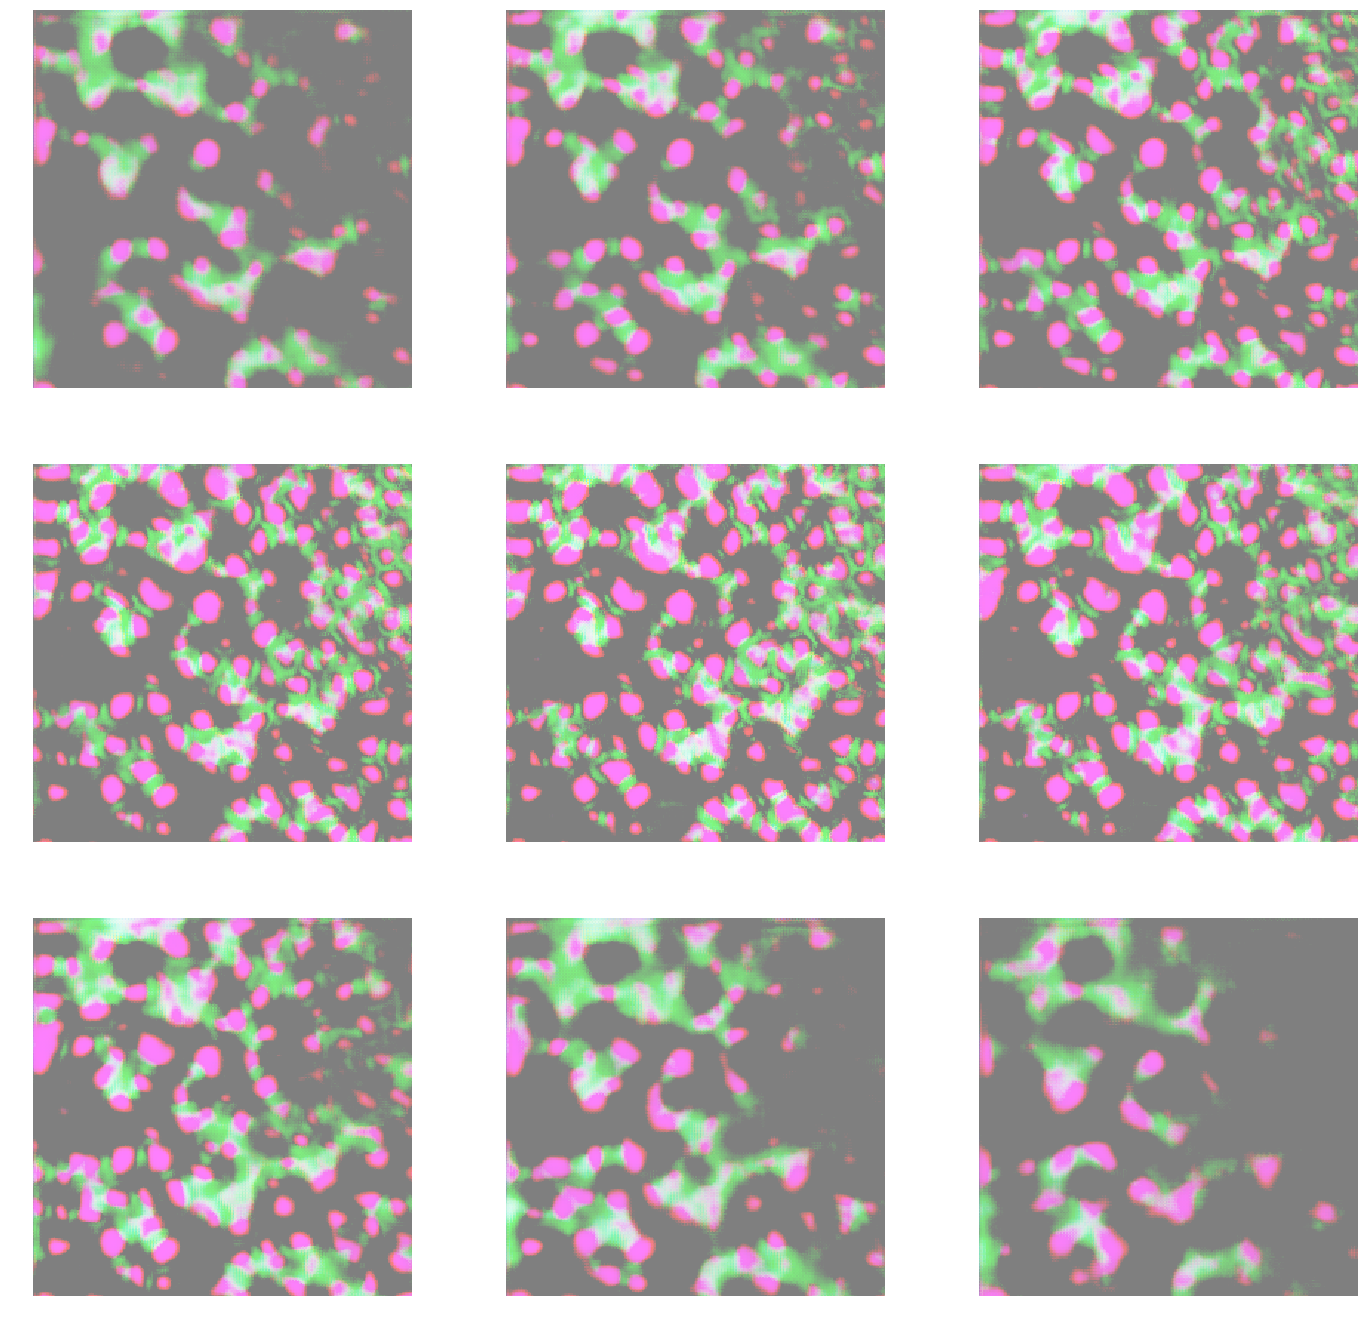

In [109]:
crop = [slice(0, 256), slice(0, 256)]
visualize.display_images([
    #img_nuc_border[i][crop].astype(float) 
    img_pred[i][crop].astype(float) 
    for i in range(img_nuc_border.shape[0])
], size=24, cols=3, cmap='viridis')